# Modeling Crop Yield

In [3]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [4]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2"
country_code = "ZMB"
points = "4"
num_features = "1000"
feature_file_name = (f'{satellite}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [5]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [6]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [7]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [8]:
list(set(country_districts) - set(crop_districts))

[]

In [9]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [10]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [11]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [12]:
features = geopandas.GeoDataFrame()
for yr in range(2016, 2019):
    print("Opening:", yr)
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
Joining: 2016
Appending: 2016
features.shape: (15088, 1006)

Opening: 2017
Joining: 2017
Appending: 2017
features.shape: (30176, 1006)

Opening: 2018
Joining: 2018
Appending: 2018
features.shape: (45264, 1006)



In [13]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [14]:
features = features.dropna(subset=['index_right']
                          ).drop(['year_right'], axis = 1
                                ).rename(columns = {"index_right": "district", "year_left": "year"})

In [31]:
features["district"]

1          Sesheke
2          Sesheke
3          Sesheke
5        Shangombo
6        Shangombo
           ...    
45259     Siavonga
45260     Siavonga
45261     Siavonga
45262       Gwembe
45263       Gwembe
Name: district, Length: 44940, dtype: object

In [32]:
features[features["district"] == "Sesheke"]

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,year,month,geometry,district,yield_mt
1,0.0,1.357831,0.000004,0.011322,0.002264,0.0,0.124482,1.537966e-05,0.0,1.154580,...,0.050146,0.000341,0.000000,0.005769,1.346143,2016,3,POINT (23.32750 -17.53819),Sesheke,0.519042
2,0.0,2.062788,0.000000,0.000472,0.004178,0.0,0.201085,1.541693e-06,0.0,1.440533,...,0.024448,0.000000,0.000000,0.002898,1.455893,2016,3,POINT (23.42330 -17.44970),Sesheke,0.519042
3,0.0,1.277021,0.000000,0.001886,0.000015,0.0,0.051624,0.000000e+00,0.0,1.028382,...,0.056080,0.000000,0.000000,0.000000,1.366949,2016,3,POINT (23.23534 -17.44622),Sesheke,0.519042
9,0.0,1.589482,0.000018,0.014049,0.004155,0.0,0.176477,8.494863e-07,0.0,1.340680,...,0.042922,0.000104,0.000000,0.004808,1.380027,2016,3,POINT (23.33111 -17.35778),Sesheke,0.519042
10,0.0,1.509842,0.000000,0.000007,0.000008,0.0,0.045022,0.000000e+00,0.0,1.026468,...,0.079216,0.000000,0.000000,0.000000,1.399879,2016,3,POINT (23.42680 -17.26926),Sesheke,0.519042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42141,0.0,0.593007,0.000000,0.012775,0.000015,0.0,0.026922,0.000000e+00,0.0,0.669766,...,0.135305,0.007044,0.000000,0.005416,1.231438,2018,6,POINT (25.03817 -15.93618),Sesheke,0.498478
42142,0.0,0.744953,0.000000,0.002445,0.000000,0.0,0.014377,0.000000e+00,0.0,0.722673,...,0.085741,0.007503,0.000000,0.004963,1.267871,2018,6,POINT (25.13072 -16.02737),Sesheke,0.498478
42144,0.0,0.479172,0.000000,0.002489,0.000000,0.0,0.006728,0.000000e+00,0.0,0.576174,...,0.143453,0.007501,0.000000,0.006169,1.219293,2018,6,POINT (25.22335 -16.11852),Sesheke,0.498478
42162,0.0,0.014995,0.000000,0.000743,0.000013,0.0,0.001542,0.000000e+00,0.0,0.030062,...,0.587633,0.288968,0.002909,0.291631,1.061777,2018,6,POINT (24.94571 -15.84497),Sesheke,0.498478


In [13]:
if satellite == "landsat-8-c2-l2":
    na = features[features.isna().any(axis = 1)]
    na.plot(figsize = (15,15), markersize = 1)
    # plt.savefig(f'images/nans.jpg', dpi=300)
    features = features.dropna()

In [14]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [15]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Model

In [16]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [18]:
len(y_all)

216

In [19]:
len(x_train)

172

In [20]:
len(x_test)

44

In [21]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

/opt/python/3.7.7/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/python/3.7.7/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/python/3.7.7/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/python/3.7.7/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.67541e-18): result may not be accurate.
  overwrite_a=False)
/opt/python/3.7.7/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWa

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [22]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.35


In [23]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

# plt.figure()
# plt.scatter(y_pred, y_all, alpha=1, s=4)
# plt.xlabel("Predicted", fontsize=15)
# plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
#           fontsize=12, y=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.text(0.1, .75,
#          s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
#          fontsize=15, fontweight="bold")

# m, b = np.polyfit(y_pred, y_all, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
# plt.gca().spines.right.set_visible(False)
# plt.gca().spines.top.set_visible(False)

# plt.show()
# plt.close()

In [24]:
# spearmanr(y_pred, y_all)

In [25]:
# pearsonr(y_pred, y_all)

In [26]:
# spearmanr(y_pred, y_all)

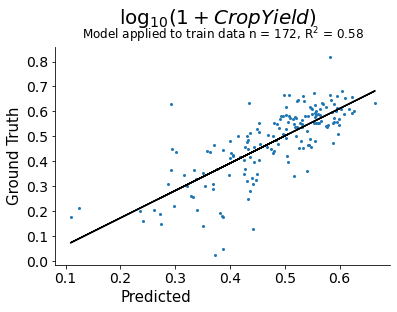

In [27]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [28]:
r2_score(y_train, y_pred)

0.5825106249114833

In [29]:
pearsonr(y_pred, y_train)

(0.7661037156861962, 1.8339589237167767e-34)

In [30]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.7753211500319557, pvalue=9.25253291807251e-36)

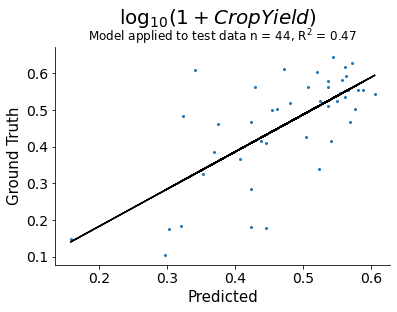

In [31]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [32]:
r2_score(y_test, y_pred)

0.47388845041076955

In [33]:
pearsonr(y_pred, y_test)

(0.6936823759231419, 1.7847195261032408e-07)

In [34]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.6219873150105708, pvalue=6.57800534133343e-06)

In [35]:
pred_features = features.copy()
x_all = pred_features.drop(['year', 'geometry', 'district', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [36]:
plot_features = pred_features[pred_features.year == 2018]
# pred_features

<AxesSubplot:>

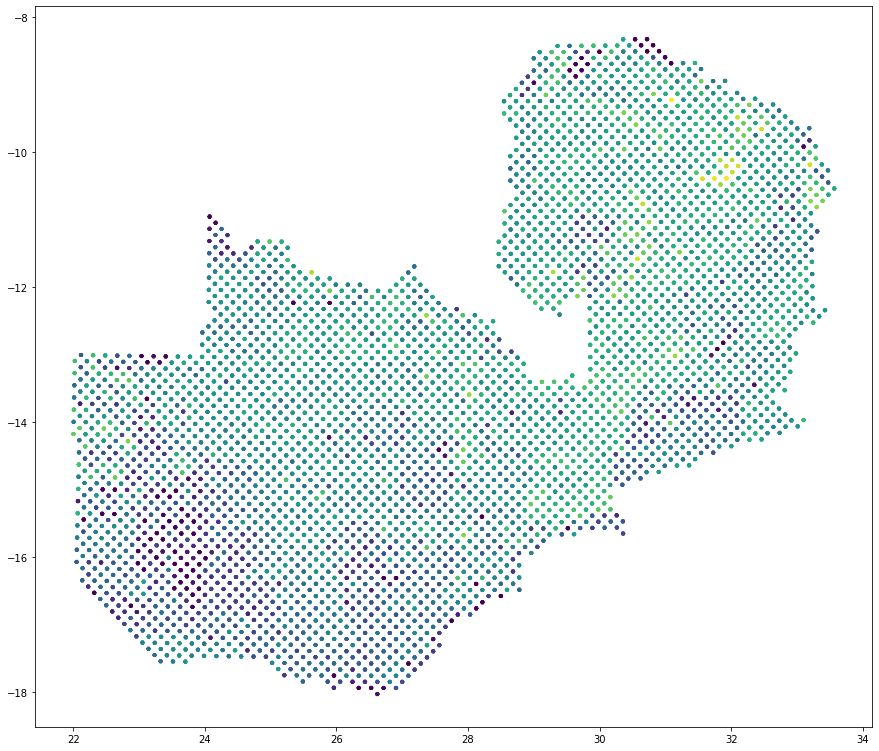

In [37]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 12,
                   alpha = .9,
                   column = 'fit')